# Wskaźnik giełdowy MACD
**Autor: Bartosz Żylwis 184477**

## Wstęp
Głównym celem projektu była implementacja wskaźnika MACD, będącego najpopularniejszym wskaźnikiem analizy technicznej.
Projekt został wykonany przy użyciu Pythona i bibliotek pandas, matplotlib. Do implementacji i analizy wskaźnika posłużyły historyczne dane indeksu WIG20 (1000 rekordów), które zostały pobrane ze strony [stooq.pl](https://stooq.pl/q/d/?s=wig20&c=0&d1=20180202&d2=20220321).

#### Wczytanie danych i wyświetlenie wykresu wartości indeksu WIG20

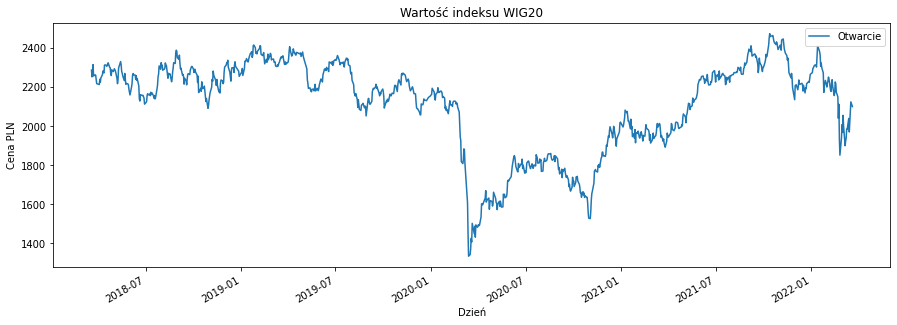

In [1]:
import os
import pandas as pd
import math

import matplotlib.pylab as plt
from datetime import datetime, timedelta

# loading csv file as DataFrame
df = pd.read_csv('wig20_d.csv', usecols=['Data', 'Otwarcie'])

plt.rcParams['figure.figsize'] = [15, 5]
df['Data'] = pd.to_datetime(df['Data'])

df.plot(x=0, y=1)
plt.title("Wartość indeksu WIG20")
plt.xlabel("Dzień")
plt.ylabel("Cena PLN")
plt.show()

## Funkcja wyliczająca EMA
Do wyznaczenie wskaźnika MACD niezbędna będzie funkcja wyznaczająca wykładniczą średnią kroczącą - **EMA**. Funkcja calculate_EMA wyliczba wartość EMA dla wartości Otwarcia dnia podanego jako argument `day`. Ze względu na definicję MACD = EMA12 - EMA 26, pominięte zostają piersze 26 dni. W przeciwnym razie dla początkowych wartości "wskaźnik MACD" nie byłby miarodajny. Dodatkowo ustawiając argument `signal` na True, możemy policzyć EMA dla wartości MACD

In [31]:
def calculate_EMA (dataFrame, day, N, signal=False):
    end_index = df.index[df.Data == day]

    if end_index[0] - 27 < 0:
        #N += end_index[0] - N
        return 0

    beg_index = end_index - N - 1
    #print(beg_index, end_index, N)

    alpha = 2 / (N + 1)
    top = 0
    bot = 0
    i = 0

    # selecting only dates that will be used
    frame = dataFrame[beg_index[0]: end_index[0]]
    frame = frame.sort_values(by=['Data'], ascending=False)

    for index, p in frame.iterrows():
        if signal:
            top += p['MACD'] * pow(1-alpha, i)
        else:
            top += p['Otwarcie'] * pow(1-alpha, i)
        bot += pow((1-alpha), i)
        i += 1

    if bot == 0:
        return 0

    EMA=top/bot
    return EMA    

### Wyznaczenie wartości MACD i SIGNAL dla poszczególnych dni


In [32]:
df['MACD'] = 0.0
df['SIGNAL'] = 0.0

for (index, row) in df.iterrows():
    df.loc[index, 'MACD'] = calculate_EMA(df, row['Data'], 12) - calculate_EMA(df, row['Data'], 26)
    df.loc[index, 'SIGNAL'] = calculate_EMA(df, row['Data'], 9, True)

### Wykres danych wejściowych i wykres wskaźnika MACD

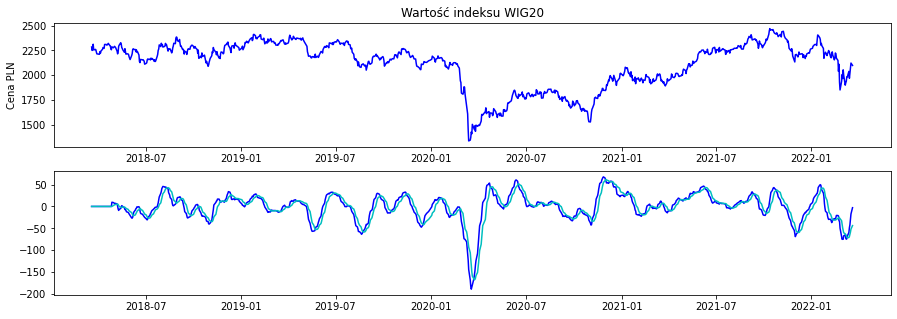

In [33]:
plt.subplot(2, 1, 1)
plt.title("Wartość indeksu WIG20")
plt.xlabel("")
plt.ylabel("Cena PLN")

plt.plot(df['Data'], df['Otwarcie'], 'b')

# ploc with MACD and SIGNAL
plt.subplot(2,1,2)
plt.plot(df['Data'], df['MACD'] ,'b', df['Data'], df['SIGNAL'], 'c')
plt.show()

## Ocena przydatności MACD
Z powyższych wykresów wynika, że wskaźnik MACD może być pomocny w analizie technicznej. Podąża on za trendami, lecz warto zauważyć, że robi to z lekkim opóźnieniem. Po zmianie trendu indeksu, wskaźnik MACD potrzebuje kilku dni na zmianę. W związku z tym, wskaźnik MACD jest najbardziej pomocny przy analizie spółek, które nie zmieniają drastycznie swojej ceny w przeciągu kilku dni lub przy analizie długoterminowej.

## Algorytm który na podstawie MACD podejmuje decyzje o kupnie/sprzedaży
1. Oblicza wartość MACD i SIGNAL w danym dniu
2. Analizuje wartości i stwierdza czy jest to sygnał sprzedarzy czy kupna
3. Kupuje / sprzedaje

In [34]:
# analyzes data
# return 0  : not time to take action
# return 1  : time tu buy
# return -1 : time to sell
def analyze_data(data, index):
    if index < 1:
        return 0
    nowMACD = data.loc[index, 'MACD']
    nowSIG = data.loc[index, 'SIGNAL'] 
    preMACD = data.loc[index -1, 'MACD']
    preSIG = data.loc[index-1, 'SIGNAL'] 
    
    if nowMACD == 0 or nowSIG == 0:
        return 0

    if nowSIG > nowMACD:
        return -1
    return 1

def buy(founds, shares_nbr, price):
    amount = int((founds / price) * 100) / 100
    founds -=amount * price
    founds = int(founds * 100) / 100
    shares_nbr += amount
    return founds, shares_nbr
    
def sell(founds, shares_nbr, price):
    founds += shares_nbr * price
    founds = int(founds * 100) / 100
    shares_nbr = 0
    return founds, shares_nbr

## Symulacja podejmowania decyzji kupna/sprzedaży na podstawie MACD
Rozpoczęcie z kapitałem (shares_nbr) równym 1000 i wykonywanie akcji zgodnych z wyznacznikiem MACD


In [35]:
founds = 0
shares_nbr = 1000
is_in = True

df['ACTION'] = 0

for (index, row) in df.iterrows():
    df.loc[index, 'MACD'] = calculate_EMA(df, row['Data'], 12) - calculate_EMA(df, row['Data'], 26)
    df.loc[index, 'SIGNAL'] = calculate_EMA(df, row['Data'], 9, True)
    action = analyze_data(df, index)
    
    if action == 1 and not is_in:
        founds, shares_nbr = buy(founds, shares_nbr, df.loc[index, 'Otwarcie'])
        is_in = True
        df.loc[index, 'ACTION'] = 1
    elif action == -1 and is_in:
        founds, shares_nbr = sell(founds, shares_nbr, df.loc[index, 'Otwarcie'])
        is_in=False
        df.loc[index, 'ACTION'] = -1

profit=(shares_nbr * df['Otwarcie'].iloc[-1] + founds) / (1000*df['Otwarcie'][0])
print("Kapitał po inwestowaniu przy pomocy MACD:", shares_nbr, ", czyli zysk =", round(profit,4), 
      '(',round(profit*100 - 100, 2), '% )' )

Kapitał po inwestowaniu przy pomocy MACD: 1284.65 , czyli zysk = 1.1798 ( 17.98 % )


## Wykres przedstawiający działania podjęte na podstawie wskaźnika MACD

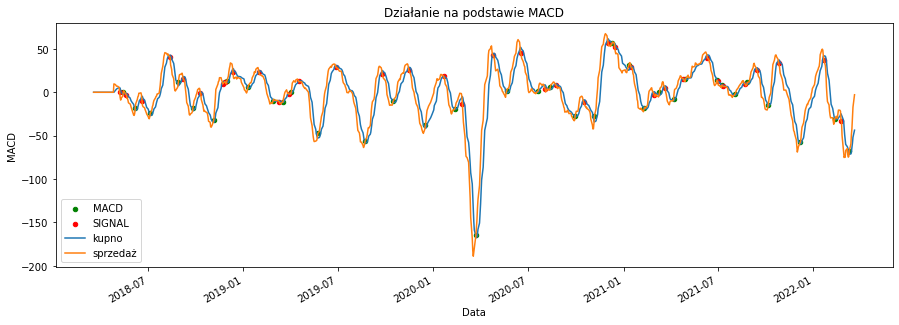

In [36]:
buying = df[df['ACTION'] == 1]
selling = df[df['ACTION'] == -1]

buy_scat = buying.plot.scatter(x=0, y=2,label="MACD",c='Green',)
sellbuy_scat = selling.plot.scatter(x=0, y=2, c='Red', ax=buy_scat, label="SIGNAL")
sss = df.plot(x=0, y=3, ax=sellbuy_scat, label='kupno')
piceplt = df.plot(x=0, y=2, ax=sss, label="sprzedaż", title="Działanie na podstawie MACD")

plt.show()

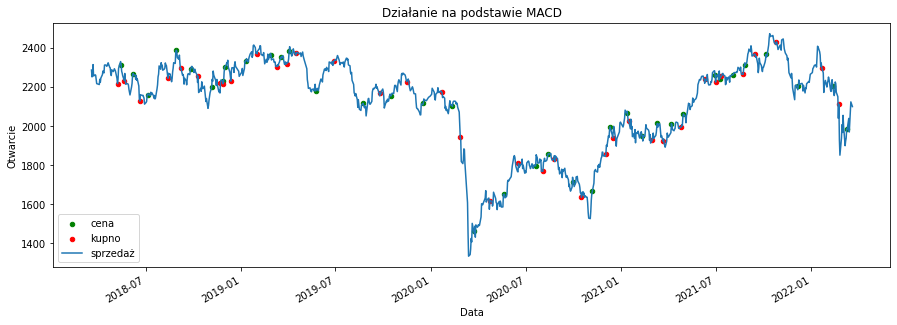

In [37]:
buying = df[df['ACTION'] == 1]
selling = df[df['ACTION'] == -1]

buy_scat = buying.plot.scatter(x=0, y=1,label="cena",c='Green',)
sellbuy_scat = selling.plot.scatter(x=0, y=1, c='Red', ax=buy_scat, label="kupno")
piceplt = df.plot(x=0, y=1, ax=sellbuy_scat, label="sprzedaż", title="Działanie na podstawie MACD")

plt.show()

## Wnioski

Wskaźnik MACD jest przydatny w długoterminowej analizie technicznej spółek. Potwierdzeniem tego jest zaprezentowany algorytm podejmujący działania no podstawie tego wskaźnika. Udało mu się wypracować zysk na poziomie 16%. Jest to zaskakująco dobry wynik. Warto jednak zaznaczyć, że MACD nie jest idealny. Na wykresie "Działanie na podstawie MACD" można zauważyć, że działa on z lekkim opóźnieniem. 
![opóźnienie MACD](opoznienie_macd.png)\
Przy nagłej zmianie trendu, wskaźnik reaguje z opóźnieniem i uzyskuje relatywnie duże straty. W związku z tym najlepiej się sprawdzi przy inwestowaniu w stabilne akcje rozpatrując je długoterminowo.
